In [81]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt

In [82]:
df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
df.head()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11109 non-null  int64  
 1   name                                      11108 non-null  object 
 2   lang                                      11109 non-null  object 
 3   bot                                       11109 non-null  int64  
 4   created_at                                11109 non-null  object 
 5   statuses_count                            11109 non-null  int64  
 6   account_age_in_days                       11109 non-null  int64  
 7   number_of_tweets                          11109 non-null  int64  
 8   account_average_tweets_per_day            11109 non-null  float64
 9   avg_tweets_per_actual_day                 11109 non-null  float64
 10  day_with_most_tweets              

# Pre processing

Dropping features not considered interesting

In [83]:
features_to_drop = [
    "user_id",
    "name",
    "created_at",
    "day_with_most_tweets"
]

df.drop(features_to_drop, axis=1, inplace=True)

## One hot encoding

Among our feature, the "lang" one is the only one suitable for one-hot encoding

In [84]:
df = pd.get_dummies(df, columns=["lang"])
df.head()

,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,entropy_for_minute,...,lang_ko,lang_nl,lang_pl,lang_pt,lang_ru,lang_sv,lang_tr,lang_xx-lc,lang_zh-CN,lang_zh-TW
0,1,76,1314,126,0.057839,4.666667,18,2.903992,2.762944,1.867539,...,0,0,0,0,0,0,0,0,0,0
1,0,54,1311,116,0.041190,4.640000,17,2.942683,2.881816,1.909614,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2709,4,0.001107,2.000000,3,1.000000,0.918296,0.918296,...,0,0,0,0,0,0,0,0,0,0
3,1,50,2080,1358,0.024038,8.035503,143,3.543607,1.320785,0.474758,...,0,0,0,0,0,0,0,0,0,0
4,0,7085,1198,3434,5.914023,28.380165,50,4.253096,1.705484,0.510899,...,0,0,0,0,0,0,0,0,0,0


## Training and test set creations

In [85]:
bot_series = df.pop("bot")

In [86]:
train_set, test_set, train_label, test_label = train_test_split(
    df, 
    bot_series, 
    stratify=bot_series, 
    test_size=0.30
)

# Naive Bayes

## Gaussian

In [87]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [88]:
train_pred_gnb = gnb.predict(train_set)
test_pred_gnb = gnb.predict(test_set)

### Evaluating obtained scores

**Accuracy:** the number of correct predictions divided by the total number of predictions  
**Precision:** the number of positive class predictions that actually belong to the positive class  
**Recall:** recall quantifies the number of true positives as compared to correct classifications  
**F1 score:** F-Measure provides a single score that balances both the concerns of precision and recall in one number.  
**Support:** Compute precision, recall, F-measure and support for each class.  

In [89]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_gnb))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision train set ', metrics.precision_score(train_label, train_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_gnb))

Accuracy train set  0.7358539094650206
Accuracy test set  0.744974497449745
Precision train set  0.7519030879401635
Recall train set  0.7358539094650206
F1 score train set  0.7251198649369941
Support train set  (array([0.81042654, 0.70412466]), array([0.53819742, 0.89722028]), array([0.64683631, 0.7890304 ]), array([3495, 4281]))


In [90]:
def report_scores(test_label, test_pred):
    print(metrics.classification_report(test_label, 
                            test_pred, 
                            target_names=['Real users', 'Bots']))
    
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

  Real users       0.82      0.55      0.66      1498
        Bots       0.71      0.90      0.80      1835

    accuracy                           0.74      3333
   macro avg       0.77      0.73      0.73      3333
weighted avg       0.76      0.74      0.74      3333



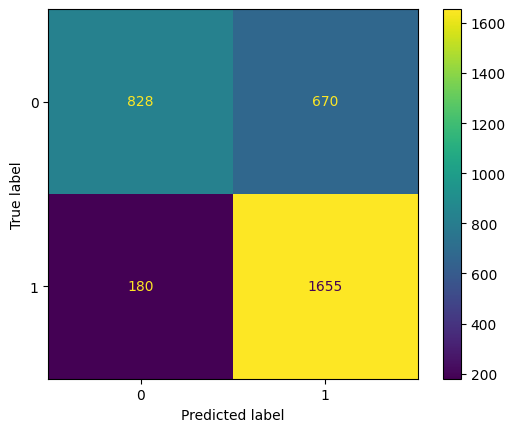

In [91]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_label, y_pred=test_pred_gnb)
plt.show() 

**Compute ROC curve**

ROC curve plots TP (on the y-axis) against FP (on the x-axis)

Meaning for (TP, FP) coordinates:
* (0,0): declare everything to be negative class
* (1,1): declare everything to be positive class
* (0,1): ideal

Diagonal line corresponds to random guessing

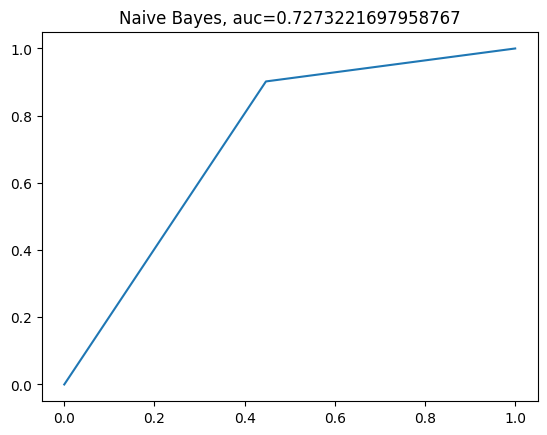

In [92]:
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)

plt.title(f"Naive Bayes, auc={auc}")
plt.plot(
    fpr,
    tpr
)

## Putting all together

Gaussian Non scaled data
Accuracy train set  0.7358539094650206
Accuracy test set  0.744974497449745
Precision train set  0.7519030879401635
Recall train set  0.7358539094650206
F1 score train set  0.7251198649369941
Support train set  (array([0.81042654, 0.70412466]), array([0.53819742, 0.89722028]), array([0.64683631, 0.7890304 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.82      0.55      0.66      1498
        Bots       0.71      0.90      0.80      1835

    accuracy                           0.74      3333
   macro avg       0.77      0.73      0.73      3333
weighted avg       0.76      0.74      0.74      3333



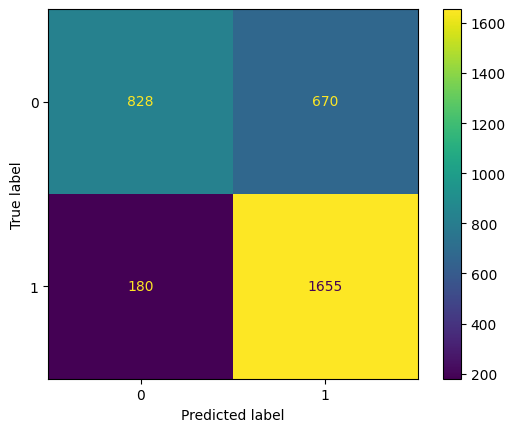

Gaussian Scaled data
Accuracy train set  0.6472479423868313
Accuracy test set  0.6618661866186618
Precision train set  0.7699131142324751
Recall train set  0.6472479423868313
F1 score train set  0.5792404529758838
Support train set  (array([0.96534653, 0.61036165]), array([0.22317597, 0.99345947]), array([0.36253776, 0.7561561 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.97      0.26      0.41      1498
        Bots       0.62      0.99      0.76      1835

    accuracy                           0.66      3333
   macro avg       0.79      0.62      0.58      3333
weighted avg       0.78      0.66      0.60      3333



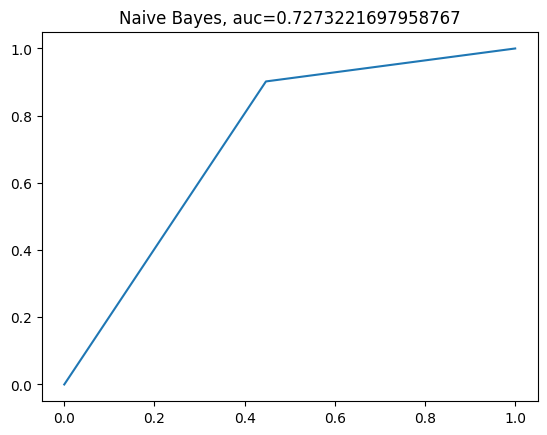

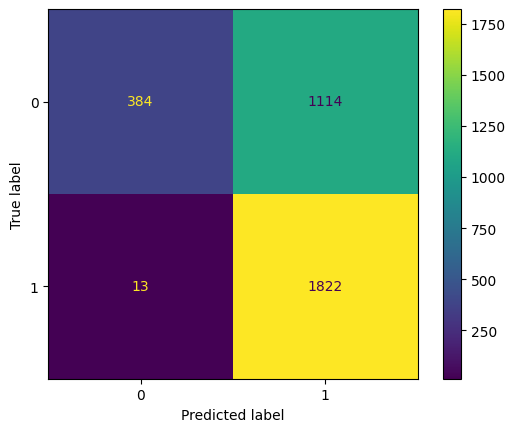




Bernoulli Non scaled data
Accuracy train set  0.6682098765432098
Accuracy test set  0.6825682568256826
Precision train set  0.6943551906512592
Recall train set  0.6682098765432098
F1 score train set  0.6657898328890938
Support train set  (array([0.59819704, 0.77285852]), array([0.79742489, 0.56271899]), array([0.68359088, 0.6512571 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.61      0.81      0.70      1498
        Bots       0.79      0.58      0.67      1835

    accuracy                           0.68      3333
   macro avg       0.70      0.69      0.68      3333
weighted avg       0.71      0.68      0.68      3333



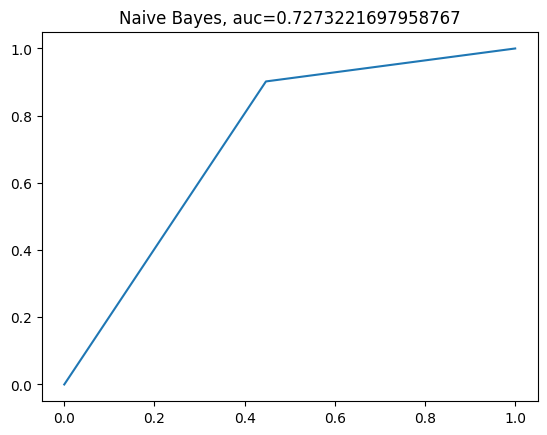

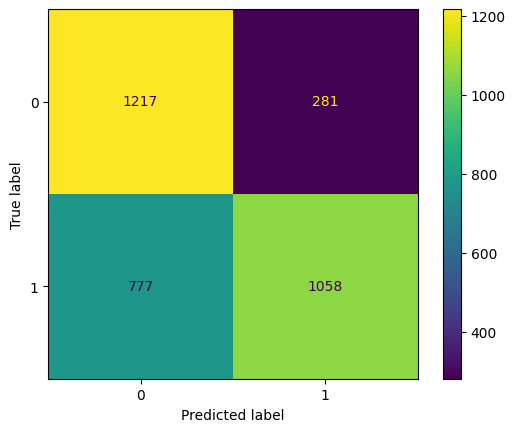

Bernoulli Scaled data
Accuracy train set  0.6683384773662552
Accuracy test set  0.6852685268526852
Precision train set  0.6941445077678687
Recall train set  0.6683384773662552
F1 score train set  0.6659954896736631
Support train set  (array([0.59849462, 0.77223289]), array([0.7962804 , 0.56388694]), array([0.68336403, 0.65181585]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.61      0.81      0.70      1498
        Bots       0.79      0.58      0.67      1835

    accuracy                           0.69      3333
   macro avg       0.70      0.70      0.68      3333
weighted avg       0.71      0.69      0.68      3333



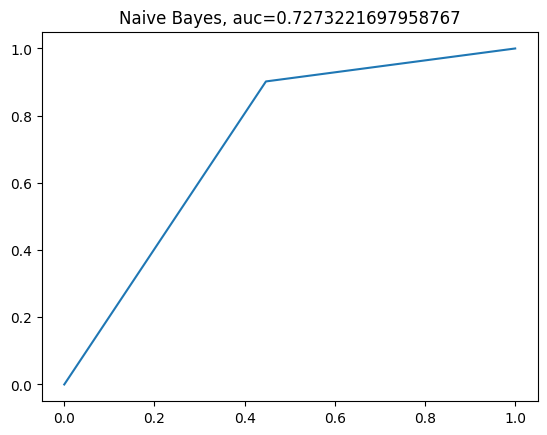

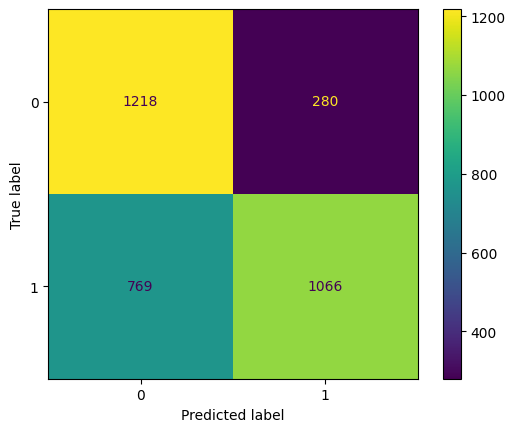




Complement Non scaled data
Accuracy train set  0.7856224279835391
Accuracy test set  0.7887788778877888
Precision train set  0.8118823214609083
Recall train set  0.7856224279835391
F1 score train set  0.7762104401853618
Support train set  (array([0.90335393, 0.73720508]), array([0.58569385, 0.94884373]), array([0.71064051, 0.8297416 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.59      0.72      1498
        Bots       0.74      0.95      0.83      1835

    accuracy                           0.79      3333
   macro avg       0.82      0.77      0.77      3333
weighted avg       0.81      0.79      0.78      3333



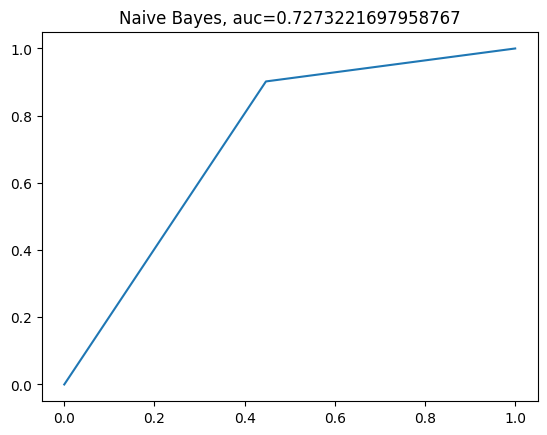

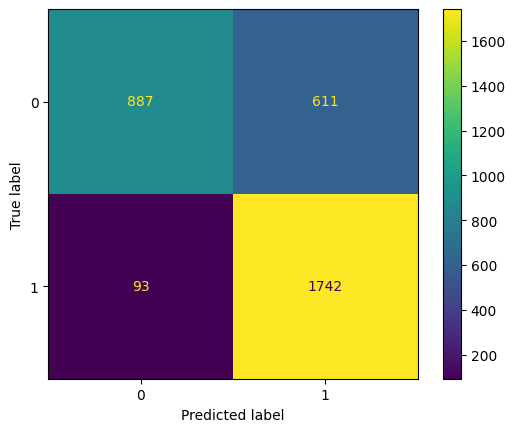

Complement Scaled data
Accuracy train set  0.8284465020576132
Accuracy test set  0.8325832583258326
Precision train set  0.8427348900746667
Recall train set  0.8284465020576132
F1 score train set  0.8241180830463004
Support train set  (array([0.91256205, 0.78572814]), array([0.68383405, 0.94650783]), array([0.78181223, 0.8586565 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.69      0.79      1498
        Bots       0.79      0.95      0.86      1835

    accuracy                           0.83      3333
   macro avg       0.85      0.82      0.82      3333
weighted avg       0.85      0.83      0.83      3333



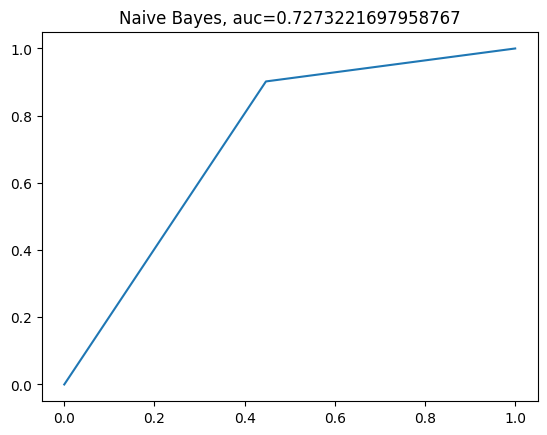

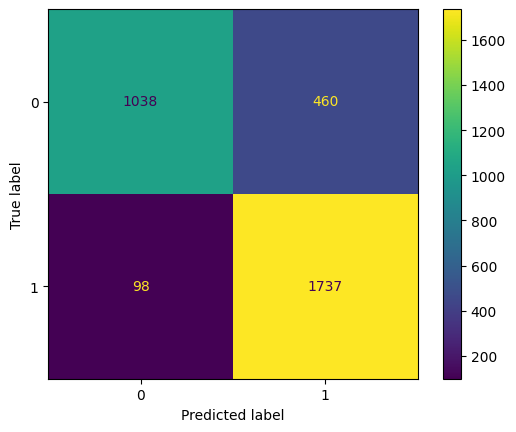




Multinomial Non scaled data
Accuracy train set  0.7856224279835391
Accuracy test set  0.7887788778877888
Precision train set  0.8118823214609083
Recall train set  0.7856224279835391
F1 score train set  0.7762104401853618
Support train set  (array([0.90335393, 0.73720508]), array([0.58569385, 0.94884373]), array([0.71064051, 0.8297416 ]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.91      0.59      0.72      1498
        Bots       0.74      0.95      0.83      1835

    accuracy                           0.79      3333
   macro avg       0.82      0.77      0.77      3333
weighted avg       0.81      0.79      0.78      3333



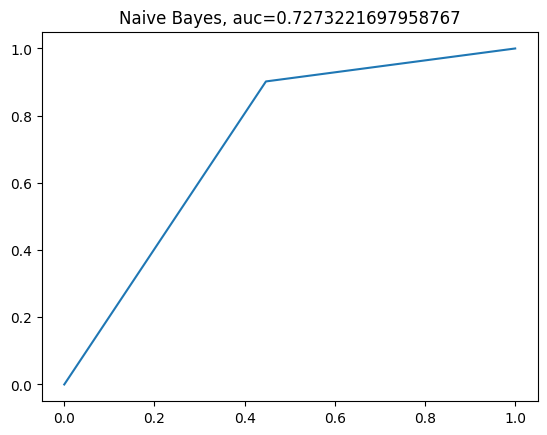

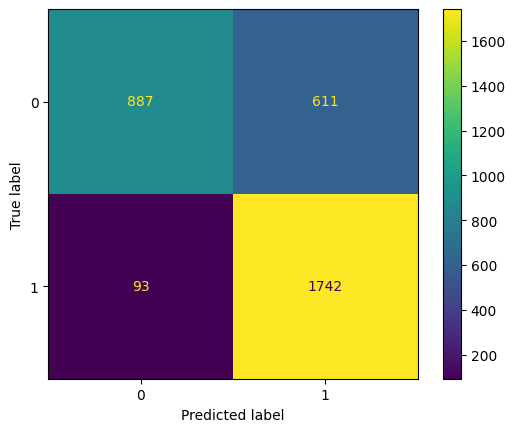

Multinomial Scaled data
Accuracy train set  0.8229166666666666
Accuracy test set  0.8304830483048304
Precision train set  0.8499868555719037
Recall train set  0.8229166666666666
F1 score train set  0.8159957666873783
Support train set  (array([0.95102215, 0.76750184]), array([0.63891273, 0.97313712]), array([0.76433339, 0.85817283]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.95      0.66      0.78      1498
        Bots       0.78      0.97      0.86      1835

    accuracy                           0.83      3333
   macro avg       0.86      0.81      0.82      3333
weighted avg       0.85      0.83      0.82      3333



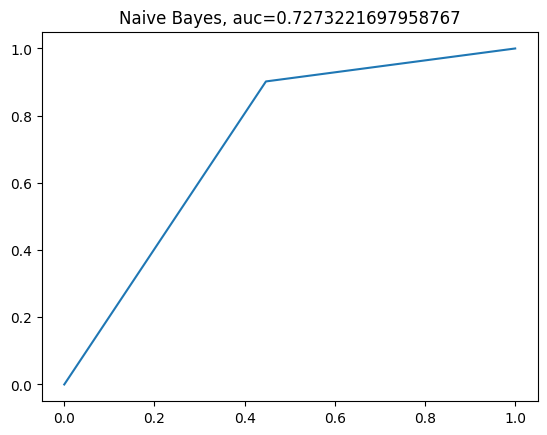

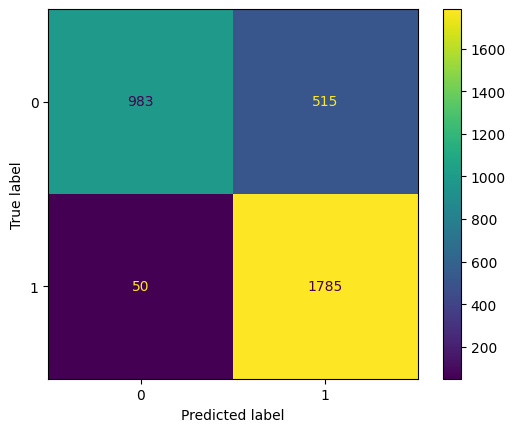

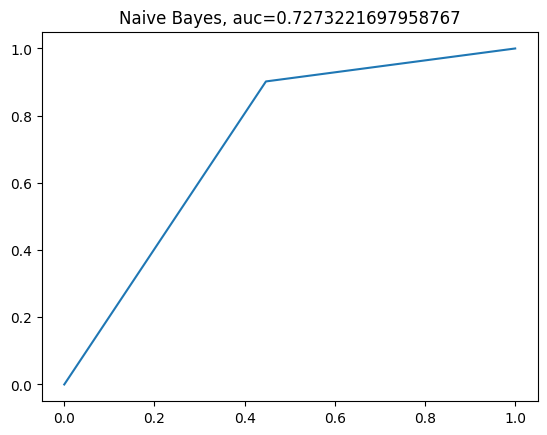

In [97]:
def process_model(nb, train_set, test_set, train_label, test_label):
    nb.fit(train_set, train_label) # fit the model
    train_pred_nb = nb.predict(train_set) # predict on train set 
    test_pred_nb = nb.predict(test_set) # predict on test set
    # print scores
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_nb))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_nb))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_nb, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_nb, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_nb, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_nb))
    report_scores(test_label, test_pred_nb)
    # print confusion matrix
    metrics.ConfusionMatrixDisplay.from_predictions(y_true=test_label, y_pred=test_pred_nb)
    plt.show() 
    # print auc curve
    fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
    auc = metrics.roc_auc_score(test_label, test_pred_gnb)
    plt.title(f"Naive Bayes, auc={auc}")
    plt.plot(fpr, tpr)
    
def get_scaled_data(Scaler, train_set, test_set, columns):
    """
    Given a scaler and the training/test set, returns the scaled datasets in pandas
    dataframes
    """
    scaled_train_set = Scaler.fit_transform(train_set.values)
    scaled_test_set = Scaler.fit_transform(test_set.values)
    train_set = pd.DataFrame(data=scaled_train_set, columns=columns)
    test_set = pd.DataFrame(data=scaled_test_set, columns=columns)
    return train_set, test_set

models = [
    ("Gaussian", GaussianNB()),
    ("Bernoulli", BernoulliNB()),
    #("Categorical", CategoricalNB()), # makes my computer crash
    ("Complement", ComplementNB()),
    ("Multinomial", MultinomialNB())
]

scaled_train_set, scaled_test_set = get_scaled_data(MinMaxScaler(), train_set, test_set, df.columns)
for model_name, nb in models:
    print(f"{model_name} Non scaled data")
    process_model(nb, train_set, test_set, train_label, test_label)
    print(f"{model_name } Scaled data")
    process_model(nb, scaled_train_set, scaled_test_set, train_label, test_label)
    print("\n\n")

## Ensemble of all previously seen classifiers

Non scaled data

Accuracy train set  0.7941100823045267
Accuracy test set  0.7956795679567957
Precision train set  0.8132480214758961
Recall train set  0.7941100823045267
F1 score train set  0.7869724856983364
Support train set  (array([0.89003295, 0.75056096]), array([0.61831187, 0.93763139]), array([0.72969779, 0.83373144]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.90      0.62      0.73      1498
        Bots       0.75      0.94      0.84      1835

    accuracy                           0.80      3333
   macro avg       0.82      0.78      0.78      3333
weighted avg       0.82      0.80      0.79      3333



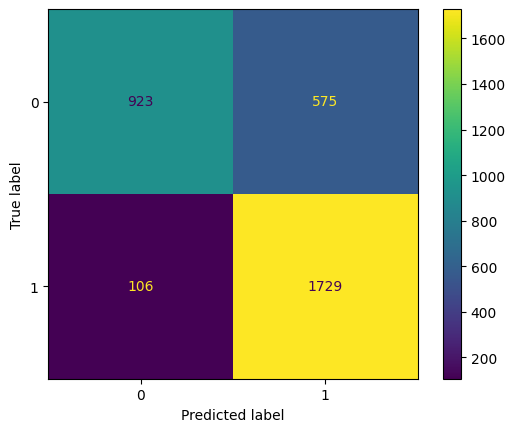

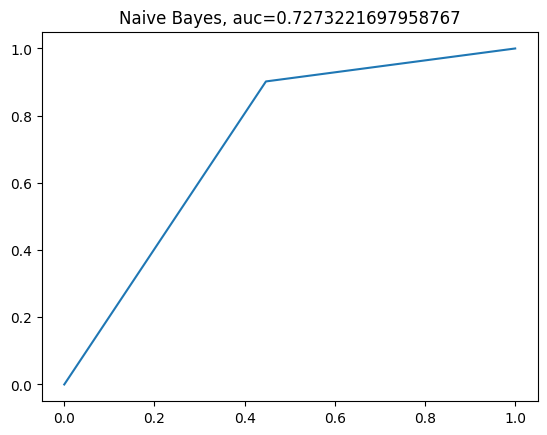

In [99]:
eclf = VotingClassifier(
    estimators=models,
    voting='hard'
)

process_model(eclf, train_set, test_set, train_label, test_label)

Scaled Data

Accuracy train set  0.8352623456790124
Accuracy test set  0.8412841284128413
Precision train set  0.856046028503808
Recall train set  0.8352623456790124
F1 score train set  0.8300837190912312
Support train set  (array([0.94457831, 0.78376844]), array([0.67296137, 0.96776454]), array([0.78596491, 0.86610223]), array([3495, 4281]))
              precision    recall  f1-score   support

  Real users       0.94      0.69      0.80      1498
        Bots       0.79      0.97      0.87      1835

    accuracy                           0.84      3333
   macro avg       0.87      0.83      0.83      3333
weighted avg       0.86      0.84      0.84      3333



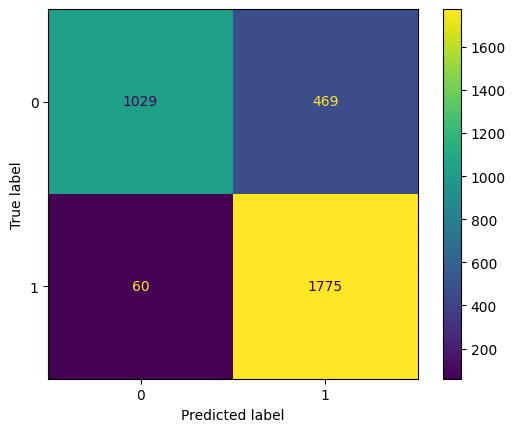

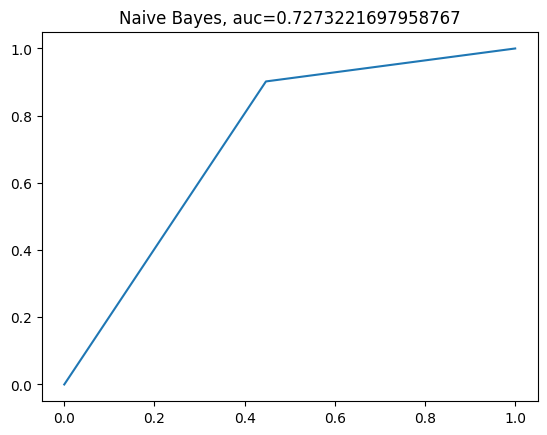

In [98]:
eclf = VotingClassifier(
    estimators=models,
    voting='hard'
)

process_model(eclf, scaled_train_set, scaled_test_set, train_label, test_label)